In [73]:
import sys
sys.path.append("/gpfs/gpfs_gl4_16mb/b9p111/b9p111ai/expanding-sdo-capabilities/src")
import torch
import numpy as np
import sdo
import logging
from sdo.datasets.sdo_dataset import SDO_Dataset
from torch.utils.data import DataLoader
from sdo.metrics.azimuth_metric import azimuthal_average, compute_2Dpsd
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def data_loader_to_XY(data_loader,verbose=False):
    start = time.time()
    data = []
    for batch_index, batch in enumerate(data_loader):
        end = time.time()
        if verbose:
            print("batch{0:03d} loading took: ".format(batch_index), end-start)
        data.append(batch.cpu())
        start = time.time()
    d = np.vstack([d.numpy() for d in data])
    #print(d.shape)
    #n_channels = d.shape[1]
    xtemp = d[:,0:3,:,:].transpose([0,2,3,1])
    # We assume the last channel loaded is the prediction target Y

    ytemp = d[:,-1,:,:]
    shape = xtemp.shape
    X = xtemp.reshape(shape[0]*shape[1]*shape[2],shape[3])
    Y = ytemp.reshape(shape[0]*shape[1]*shape[2])
    print(X.shape, Y.shape)
    return X, Y

def init_gpu(cuda_device=None):
    """ Use the GPU. """
    torch.backends.cudnn.enabled = True
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA not available! Unable to continue")
    if cuda_device is None:
        # Randomly keep trying available GPU devices.
        devices = np.random.permutation(list(range(torch.cuda.device_count())))
        success = False
        for cuda_device in devices:
            _logger.info('Trying to use CUDA device {}...'.format(cuda_device))
            try:
                device = torch.device("cuda:{}".format(cuda_device))
                torch.cuda.set_device(device)
                success = True
                break
            except Exception as error:
                _logger.exception(error)
            if not success:
                raise Exception("No CUDA device is available!")
    else:
        device = torch.device("cuda:{}".format(cuda_device))
        torch.cuda.set_device(device)

    _logger.info("Using device {} for training, current device: {}, total devices: {}".format(device, torch.cuda.current_device(), torch.cuda.device_count()))
    return device  

In [3]:
#Logger and CUDA prelims
logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
_logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")
torch.backends.cudnn.enabled = True
cuda_device = init_gpu()
print(cuda_device)
print("Using device {} for training, current device: {}, total devices: {}".format(cuda_device, torch.cuda.current_device(), torch.cuda.device_count()))
 

[2019-08-07 14:48:11] INFO:__main__:Trying to use CUDA device 3...
[2019-08-07 14:48:11] INFO:__main__:Using device cuda:3 for training, current device: 3, total devices: 6
cuda:3
Using device cuda:3 for training, current device: 3, total devices: 6


In [4]:
subsample = 4
original_ratio = 512
img_shape = int(original_ratio/subsample)
instr = ['AIA', 'AIA', 'AIA','AIA']
channels = ['0094','0171','0193','0211']
input_channels = len(channels)- 1

In [6]:
# Load data
train_data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2011, 2013], 
                         #mnt_step=1, day_step=1, h_step=24, min_step=60, 
                         subsample=subsample, 
                         test_ratio= 0.3, normalization=0, scaling=True)
test_data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2011, 2013], 
                        #mnt_step=1, day_step=1, h_step=24, min_step=60,
                        subsample=subsample, 
                        test_ratio= 0.3, normalization=0, scaling=True, test=True)
train_data_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=128, shuffle=True)

[2019-08-07 14:48:57] INFO:sdo.datasets.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOMLmm"
[2019-08-07 14:48:57] INFO:sdo.datasets.sdo_dataset:Training on months "[1 2 3 4 5 6 7]"
[2019-08-07 14:48:57] DEBUG:sdo.datasets.sdo_dataset:Timestamps requested values: 
[2019-08-07 14:48:57] DEBUG:sdo.datasets.sdo_dataset:Years: 2011,2012,2013
[2019-08-07 14:48:57] DEBUG:sdo.datasets.sdo_dataset:Months: 1,2,3,4,5,6,7
[2019-08-07 14:48:57] DEBUG:sdo.datasets.sdo_dataset:Days: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
[2019-08-07 14:48:57] DEBUG:sdo.datasets.sdo_dataset:Hours: 0,6,12,18
[2019-08-07 14:48:57] DEBUG:sdo.datasets.sdo_dataset:Minutes: 0
[2019-08-07 14:48:57] INFO:sdo.datasets.sdo_dataset:Max number of timestamps: 2604
[2019-08-07 14:49:00] INFO:sdo.datasets.sdo_dataset:Timestamps found in the inventory: 2449 (0.94)
[2019-08-07 14:49:00] INFO:sdo.datasets.sdo_dataset:N timestamps discarded because channel is missing = 

In [7]:
#Training and testing data
Xtrain, Ytrain = data_loader_to_XY(train_data_loader)
Xtest, Ytest   = data_loader_to_XY(test_data_loader)

(40009728, 3) (40009728,)
(16744448, 3) (16744448,)


In [8]:
# Initialize model
from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import GradientBoostingRegressor
model = LinearRegression()
# Train model
model.fit(Xtrain,Ytrain)
# Generate model predictions
Ypred = model.predict(Xtest)
img_pred = Ypred.reshape(int(len(Ytest)/img_shape/img_shape),img_shape,img_shape)
img_test = Ytest.reshape(int(len(Ytest)/img_shape/img_shape),img_shape,img_shape)

[2019-08-07 15:05:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:05:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:05:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:05:28] DEBUG:matplotlib.axes._base:update_title_pos


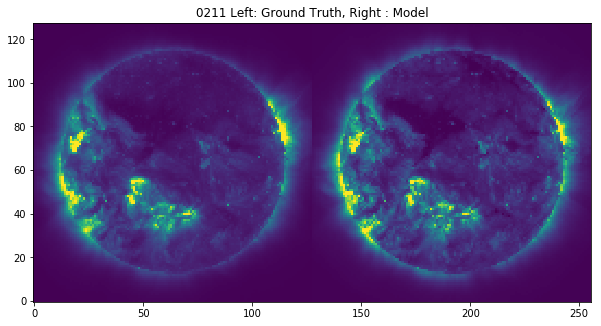

[2019-08-07 15:05:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:05:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:05:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:05:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:05:28] DEBUG:matplotlib.axes._base:update_title_pos


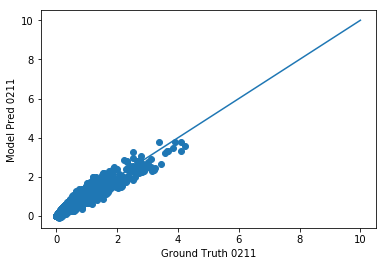

In [25]:
#Show comparison for some image picked from the test set
comp = 12
plt.figure(figsize=(1/,10))
plt.imshow(np.concatenate((img_test[comp,:,:],img_pred[comp,:,:]),axis=1),clim=(0,2),origin='lower')
plt.title('{0:s} Left: Ground Truth, Right : Model'.format(channels[-1]))
plt.show()
plt.scatter(img_test[comp,:,:],img_pred[comp,:,:])
plt.xlabel('Ground Truth {0:s}'.format(channels[-1]))
plt.ylabel('Model Pred {0:s}'.format(channels[-1]))
plt.plot([0,10],[0,10])

[2019-08-07 19:40:34] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x20012b7ff3c8>
[2019-08-07 19:40:34] DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
[2019-08-07 19:40:34] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x20012b7ff3c8>
[2019-08-07 19:40:34] DEBUG:matplotlib.colorbar:Setting pcolormesh


/gpfs/gpfs_gl4_16mb/b9p111/b9p111ar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Text(0, 0.5, 'Logarithm of the ground truth intensity')

[2019-08-07 19:40:34] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 19:40:34] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 19:40:34] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 19:40:34] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 19:40:34] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 19:40:34] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 19:40:34] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 19:40:34] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 19:40:34] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 19:40:34] DEBUG:matplotlib.axes._base:update_title_pos


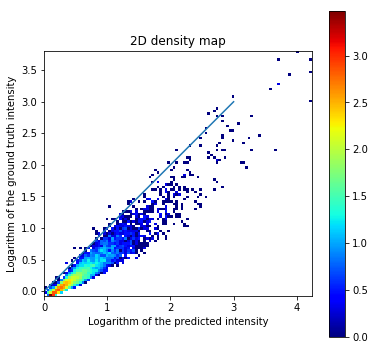

In [119]:
#Plotting a 2D histogram for the ground truth and the predicted image
plt.figure(figsize=(6,6))
H, xedges, yedges = np.histogram2d(img_test[comp,:,:].flatten(), img_pred[comp,:,:].flatten(), bins=100)
plt.imshow(np.log10(H/1.), origin='lower',
          extent=(xedges.min(), xedges.max(), yedges.min(), yedges.max()),cmap='jet')
plt.plot([xedges.min(),3],[xedges.min(),3])
plt.colorbar()
plt.title("2D density map")
plt.xlabel('Logarithm of the predicted intensity')
plt.ylabel('Logarithm of the ground truth intensity')

[2019-08-07 16:30:28] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x20012daefb70>
[2019-08-07 16:30:28] DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
[2019-08-07 16:30:28] DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x20012daefb70>
[2019-08-07 16:30:28] DEBUG:matplotlib.colorbar:Setting pcolormesh


[2019-08-07 16:30:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:28] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:29] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:29] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:29] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:29] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 16:30:29] DEBUG:matplotlib.axes._base:update_title

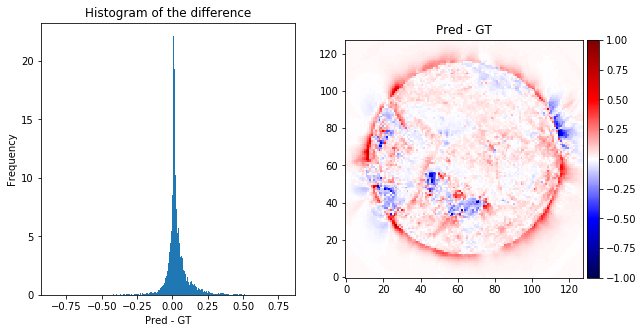

In [81]:
#The snippet below plots the histogram of the fi
fig, axs =plt.subplots(1,2,figsize=(10,5),facecolor='w', edgecolor='k')
axs=axs.ravel()
axs[0].hist((img_pred[comp,:,:]-img_test[comp,:,:]).ravel(),density=True,bins=500)
axs[0].set_title('Histogram of the difference')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Pred - GT')
im1=axs[1].imshow((img_pred[comp,:,:]-img_test[comp,:,:]),cmap='seismic',vmin=-1,vmax=1,origin='lower')
axs[1].set_title('Pred - GT')
divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)


In [28]:
psd_1Dpred = azimuthal_average(compute_2Dpsd(img_pred[0,:,:]))
psd_1Dtruth = azimuthal_average(compute_2Dpsd(img_test[0,:,:]))

Text(0, 0.5, 'Amplitude')

[2019-08-07 15:08:39] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:08:39] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:08:39] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:08:39] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:08:39] DEBUG:matplotlib.axes._base:update_title_pos


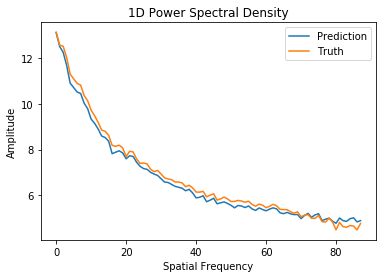

In [34]:
plt.plot(np.log(psd_1Dpred),label='Prediction')
plt.plot(np.log(psd_1Dtruth),label='Truth')
plt.legend()
plt.title('1D Power Spectral Density')
plt.xlabel('Spatial Frequency')
plt.ylabel('Amplitude')

In [49]:
def calculate_primary_metric(output, gt_output):
    """
    Given some predicted output from a network and some ground truth, this method
    calculates a scalar on how "well" we are doing for a given problem to gauge
    progress during different experiments and during training. This gives an
    idea of the MSE between the logarithm of the 1D power spectral density.
    output: Predicted 2D image
    gt_output: Ground truth 2D image
    """
    # TODO: Do this all on the GPU via Torch, rather than the CPU via Numpy.
    prediction = output#.detach().cpu().numpy()
    ground_truth = gt_output#.detach().cpu().numpy()
    # TODO: Can also include the filtering components.
    # TODO: Compute this across the entire batch, and do it at longer epoch
    # intervals because its slow.
    psd_1Dpred = azimuthal_average(compute_2Dpsd(prediction[:, :]))
    psd_1Dtruth = azimuthal_average(compute_2Dpsd(ground_truth[:, :]))
    # TODO: Create a flag that will directly compare these two values without
    # the log.
    primary_metric = mean_squared_error(np.log(psd_1Dtruth),
                                        np.log(psd_1Dpred))
    # Note: lower values are better for our primary metric here.
    return primary_metric



In [55]:
#Compute the primary metric
dim_test=img_test.shape
nsteps=1022
primary_metric=np.zeros(nsteps)
for index in range(dim_test[0]):
    primary_metric[index] =calculate_primary_metric(img_pred[index,:,:], img_test[index,:,:])    

Text(0.5, 1.0, 'Primary metric (Azimuthal average)')

[2019-08-07 15:36:38] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:36:38] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:36:38] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:36:38] DEBUG:matplotlib.axes._base:update_title_pos
[2019-08-07 15:36:38] DEBUG:matplotlib.axes._base:update_title_pos


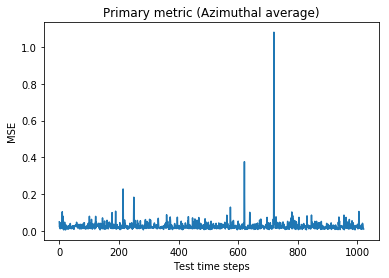

In [60]:
plt.plot(primary_metric) #Lower is better
plt.xlabel('Test time steps')
plt.ylabel('MSE')
plt.title("Primary metric (Azimuthal average)")